# Defining the problem
- Objective: Determine why and when customers are leaving.
- Business Impact: Assess how churn impacts revenue and long-term growth.

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew,kurtosis, pearsonr
import numpy as np
import seaborn as sns
from itertools import product
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('ecom-user-churn-data.csv')
df.describe()

,visitorid,ses_rec,ses_rec_avg,ses_rec_sd,ses_rec_cv,user_rec,ses_n,ses_n_r,int_n,int_n_r,...,int_cat16_n,int_cat17_n,int_cat18_n,int_cat19_n,int_cat20_n,int_cat21_n,int_cat22_n,int_cat23_n,int_cat24_n,target_class
count,4.935800e+04,49358.000000,49358.000000,49358.000000,49358.000000,49358.000000,49358.000000,49358.000000,49358.000000,49358.000000,...,49358.000000,49358.000000,49358.000000,49358.000000,49358.000000,49358.000000,49358.000000,49358.000000,49358.000000,49358.000000
mean,7.072986e+05,15.454840,11.231611,2.711961,-0.020100,33.822947,3.366445,0.172372,6.716277,1.720975,...,0.955792,0.773714,0.382977,0.732424,0.503343,0.447020,2.102577,0.038130,0.099579,0.885591
std,4.072098e+05,9.184645,18.162743,6.583917,0.917701,25.237703,7.380573,0.372614,38.528882,1.455885,...,6.086722,5.003517,4.569604,4.977989,3.259194,3.873684,16.273213,0.593681,1.135149,0.318311
min,3.700000e+01,0.000000,0.000000,0.000000,-1.000000,0.000000,2.000000,-1.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.532920e+05,7.000000,0.000000,0.000000,-1.000000,16.000000,2.000000,0.060606,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,7.100910e+05,16.000000,2.250000,0.000000,0.000000,26.000000,2.000000,0.090909,3.000000,1.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.060355e+06,23.000000,14.250000,1.000000,0.638646,46.000000,3.000000,0.166667,6.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000
max,1.407573e+06,31.000000,99.000000,47.500000,11.525121,99.000000,475.000000,18.000000,5549.000000,59.000000,...,576.000000,445.000000,481.000000,564.000000,317.000000,420.000000,2282.000000,54.000000,105.000000,1.000000


# Data prep

In [3]:
# deal with duplicates, handle missing values and anomalies.
df.isnull().sum().sum()

0

In [4]:
df.duplicated().sum()

0

## Univariate analysis
- For Skewness:
    - A skewness close to 0 indicates a symmetrical distribution.
    - A skewness greater than 1 or less than -1 indicates a highly skewed distribution.
    - A skewness between -1 and -0.5 or between 0.5 and 1 indicates moderate skewness.
- For Kurtosis:
    - A kurtosis greater than 3 indicates a leptokurtic distribution. Traditional interpretations would subtract 3 (excess kurtosis), so a value greater than 0 in this excess kurtosis indicates more outliers than the normal distribution.
    - A kurtosis less than 3 indicates a platykurtic distribution. With excess kurtosis (kurtosis - 3), a value less than 0 indicates fewer outliers. 
    
These metrics are valuable for data preprocessing in machine learning. Highly skewed or kurtotic data may need transformation, such as logarithmic, square root, or box-cox transformation, to meet the assumptions of various statistical models and algorithms.

In [5]:
#univariate analysis
def univ_analysis(x):

    """
    get quartiles, skewness, kurtosis and sparseness.
    """
    distribution_stats = [np.quantile(x, [0,.25,.5,.75,1]), skew(x), kurtosis(x),round((1 - (np.count_nonzero(x)/len(x))),4)]
    return distribution_stats


In [6]:
df.apply(univ_analysis).to_csv('df_stats.csv')

# Multicolinearity 

Here comes a question, the combination of predictor variables can have stronger impact in the response variable even if some variables from that combination have no relevant correlation with the response variable? 

The answer is, yes! Some models might underperform if we just take away variables, so let's be careful about it and perform two kinds of multicolinear analysis.

1. pearsons correlation : straightforward and maintain the interpretability of the model but might lead to the loss of some important data
2. PCA:are best when reduction of dimensions with minimal loss of information is needed.  

PCA will indicate which variable to keep when we find high correlation

In [4]:
pairs = list(product(df.columns, repeat = 2))
corr_ls = []

for c in pairs:
    pair_corr, corr_pval = pearsonr(df[c[0]],df[c[1]])
    corr_ls.append([c[0],c[1],pair_corr,corr_pval])

c:\Users\IM_py\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [5]:
x = df.drop(['int_cat15_n','target_class'], axis= 'columns').values

x = StandardScaler().fit_transform(x)

In [6]:
corr_df = pd.DataFrame(data= corr_ls,columns=['from','to','rho','pvalue'])
corr_df[(abs(corr_df['rho']) > .8 ) & (corr_df['from'] != corr_df['to'])]

,from,to,rho,pvalue
116,ses_rec_avg,ses_mo_sd,0.856849,0.0
262,user_rec,ses_mo_avg,-0.811061,0.0
263,user_rec,ses_mo_sd,0.803804,0.0
402,int_n,tran_n,0.859737,0.0
404,int_n,rev_sum,0.855076,0.0
437,int_n,int_cat22_n,0.936990,0.0
457,int_n_r,int_itm_n_avg,0.917397,0.0
463,int_n_r,ses_len_avg,0.805345,0.0
498,tran_n,int_n,0.859737,0.0
502,tran_n,rev_sum,0.981603,0.0


In [7]:
n_comp = 5
pca = PCA(n_comp)
princ_components = pca.fit_transform(x)

pc_df = pd.DataFrame(data = princ_components, columns=['PC1','PC2','PC3','PC4','PC5'])

In [8]:
loadings = pca.components_
print(pca.explained_variance_ratio_.sum())

important_features = set() 

for k in range(n_comp):  
    important_features.update([i for i in range(len(loadings[k])) if abs(loadings[k][i]) > 0.1])


important_features = sorted(list(important_features))

print(important_features)

0.4180977751843673
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 29, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46]


In [9]:
(len(important_features))/len(df.columns)
#73% of the columns explains only 42% of the variance, that suggests feature enrichment and/or feature engineering are needed

0.7551020408163265

In [10]:
df.drop(['int_cat15_n','target_class'], axis= 'columns').columns[important_features]

Index(['ses_rec', 'ses_rec_avg', 'ses_rec_sd', 'ses_rec_cv', 'user_rec',
       'ses_n', 'ses_n_r', 'int_n', 'int_n_r', 'tran_n', 'tran_n_r', 'rev_sum',
       'rev_sum_r', 'major_spend_r', 'int_cat_n_avg', 'int_itm_n_avg',
       'ses_mo_avg', 'ses_mo_sd', 'ses_ho_sd', 'ses_len_avg', 'time_to_int',
       'time_to_tran', 'int_cat1_n', 'int_cat2_n', 'int_cat5_n', 'int_cat9_n',
       'int_cat11_n', 'int_cat12_n', 'int_cat16_n', 'int_cat17_n',
       'int_cat18_n', 'int_cat19_n', 'int_cat20_n', 'int_cat21_n',
       'int_cat22_n', 'int_cat23_n', 'int_cat24_n'],
      dtype='object')

# implementing WOE and IV

for bivariate analysis

In [39]:
def calc_iv(df2,variable,target):

    
    lst = []
    #This block iterates through each unique value of the specified feature. For each unique value (val), it computes:
    #The total number of occurrences of val.
    #The count of occurrences where the target variable is 0 ("churn").
    #The count of occurrences where the target variable is 1 ("no churn").
    #These counts are appended to the list lst as a sublist, including the feature name and the value being analyzed.~

    for i in range(df2[variable].nunique()):
        
        variable_val = df2[variable].unique()[i]
        aux_df = df2[(df2[variable] == variable_val)]
        total_ocur = len(aux_df)
        total_churn = len(aux_df[(aux_df[target] == 0)])
        total_nochurn = len(aux_df[(aux_df[target] == 1)])

        lst.append([variable,variable_val,total_ocur,total_churn,total_nochurn])
        
    #Share: The proportion of observations for each unique value relative to the total number of observations.
    #share churn: The proportion of the "bad" outcome for each unique value.
    #Distribution Good Rate and Distribution Bad Rate: The distribution of good and bad rates across the unique values.
    #WoE (Weight of Evidence): A measure of the predictive power of an independent variable in separating the classes.
    woe_df = pd.DataFrame(data = lst, columns = ['feature','feature_val','total_ocur','total_churn','total_nochurn' ])

    woe_df['share'] = woe_df['total_ocur']/woe_df['total_ocur'].sum()
    woe_df['share_churn'] = woe_df['total_churn']/woe_df['total_ocur'].sum()
    woe_df['distribution_churn'] = woe_df['total_churn']/woe_df['total_churn'].sum()
    woe_df['distribution_nochurn'] = woe_df['total_nochurn']/woe_df['total_nochurn'].sum()
    woe_df['WoE'] = np.log(woe_df['distribution_nochurn']/woe_df['distribution_churn'])
    woe_df = woe_df.replace({'WoE':{np.inf: 0, -np.inf:0}})
    # Calculates the Information Value for each unique value of the feature by multiplying the WoE by the 
    #difference in distributions of the good and bad rates. The IV is a summary measure that quantifies the
    #predictive power of the independent variable.

    woe_df['IV'] = woe_df['WoE']*(woe_df['distribution_nochurn'] - woe_df['distribution_churn'])

    woe_df = woe_df.sort_values(by = ['feature','feature_val'],ascending = [True, True])

    IV = woe_df['IV'].sum()

    return IV,woe_df

In [29]:
#function to transform a numeric column in bins
def quantile_cut(col):
    tresholds = np.linspace(0,1,21)
    
    col_cut = pd.cut(col, bins = np.quantile(col.dropna(),tresholds), include_lowest = True, duplicates='drop')
    col_cut = col_cut.cat.add_categories(['NULL'])
    col_cut.fillna('NULL', inplace = True)

    return col_cut


In [30]:
df_IV = df.drop('target_class',axis = 'columns').apply(quantile_cut)

# target is removed from the quantile cut application then we put back in for the bivariate analysis

df_IV.insert(0,'target_class',df['target_class'])

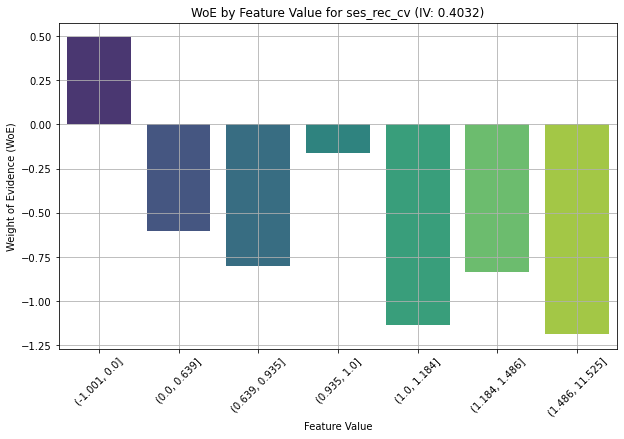

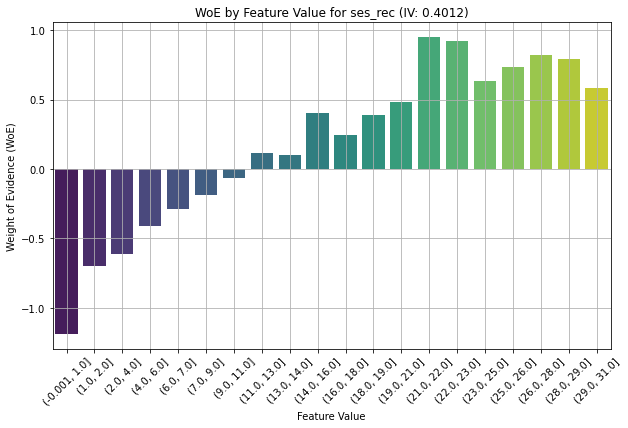

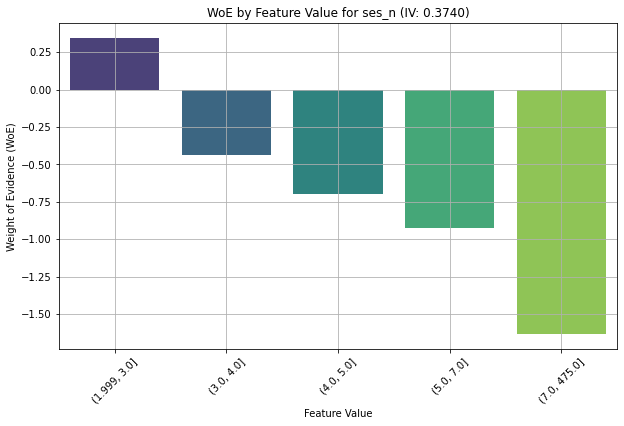

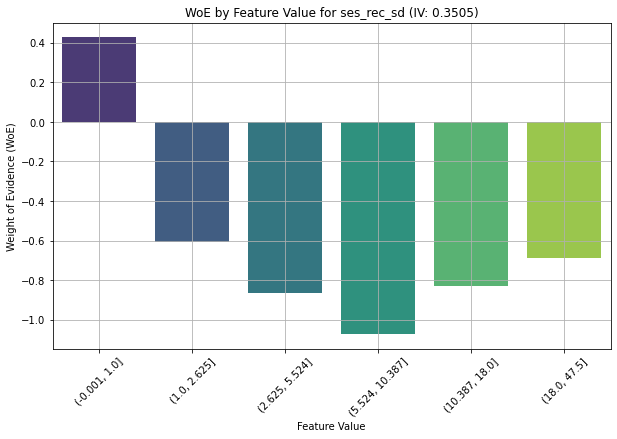

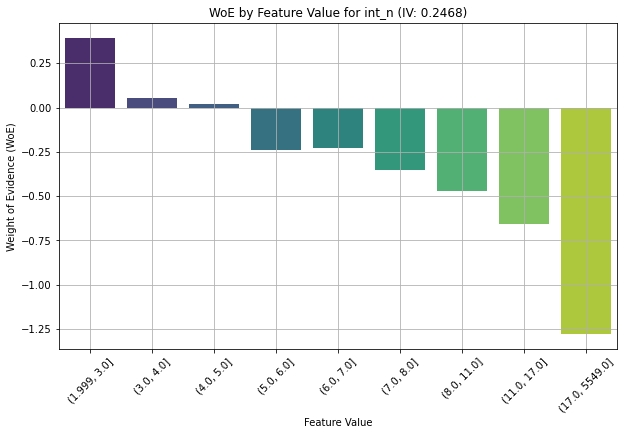

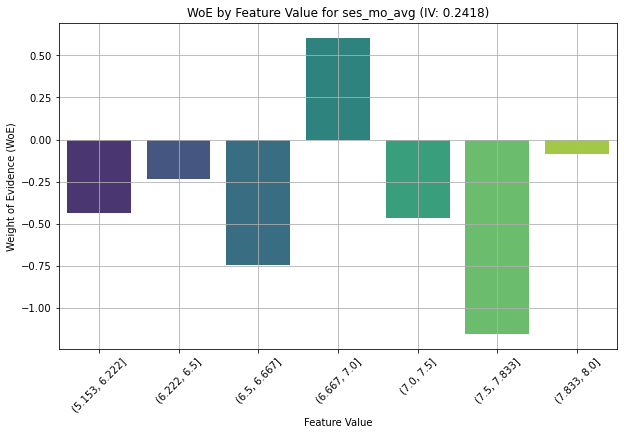

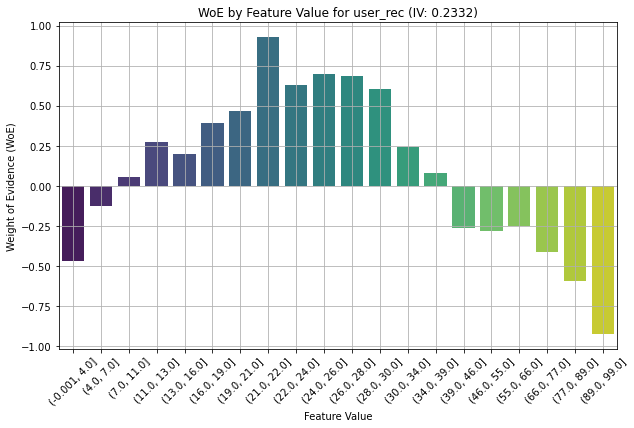

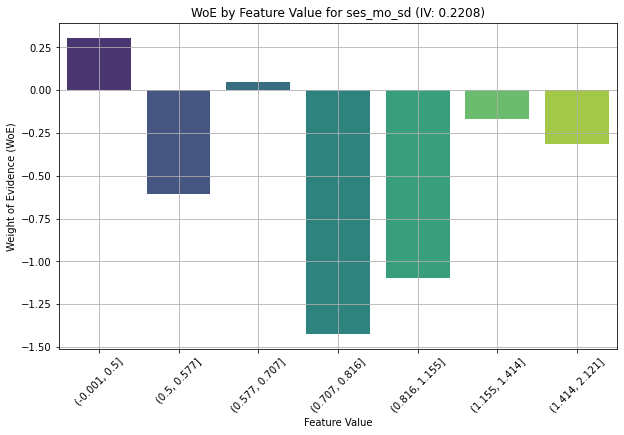

In [51]:

# Step 1: Apply calc_iv to each feature and store results
iv_results = {}
feature_details = {}

for feature in df_IV.columns:
    if feature != 'target_class': 
        IV, woe_df = calc_iv(df_IV, feature, 'target_class')
        iv_results[feature] = IV
        feature_details[feature] = woe_df

# Step 2: Get top 'n' features with the highest IV
n = 8  
top_features = sorted(iv_results, key=iv_results.get, reverse=True)[:n]

# Step 3: Plotting the WoE values for the top 'n' features
for feature in top_features:
    plt.figure(figsize=(10, 6))
    woe_df = feature_details[feature]
    ax = sns.barplot(data = woe_df,x='feature_val', y = 'WoE', palette='viridis')
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Weight of Evidence (WoE)')
    ax.set_title(f'WoE by Feature Value for {feature} (IV: {iv_results[feature]:.4f})')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


# which variables remove from start ?

now that we have good inputs on feature importance and correlation, we can keep the variables that are not highly correlated to others and also pay attention to the variables with multicolinearity, select the one with greatest IV and remove the other correlated to it.

 There's one warning tough, when removing variables, the person responsible for the analysis must have a good reason and a multi-faceted support on their decision, like checking the opinion of the stakeholder about which features are the most explanatory for the business. 